# COGS 108 Final Project

## Overview

In this project I analyzed the effects of pollutant burden and disadvantaged population characteristics on park ratings, hoping to determine which areas should be prioritized by the San Diego parks department in terms of improving parks. I used Yelp reviews and the metrics provided by CalEnviroScreen 2.0.

## Name & GitHub ID

Name: Rahul Pearce

GitHub ID: rcpearce

## Research Question

Are park ratings in a given San Diego County area more affected by population characteristic factors or pollutant burden factors?

## Background and Prior Work

   Pollutant burden is a metric used in environmental studies to determine how unsafe an environment is to live in. It takes into account factors such as drinking water contamination, traffic density, and particulate matter density to provide a holistic representation of an area's air and water safety. Such considerations are important when one has an interest in public health [1]; monitoring pollutant burden can elucidate areas in which state or local governments should invest funds to improve quality of life. Health risks associated with a high pollutant burden include premature mortality, cardiovascular and respiratory disease, and asthma [1]. To reduce disease burden, it makes sense to target pollutant burden in affected areas.
   
   Population characteristic scores, as produced by CalEnviroScreen 2.0, include level of education, employment, and linguistic isolation. This score is created in conjunction with the pollutant burden in order to assess all the factors that may contribute to a negative environment in a community. Often, people living in areas with worse population characteristic scores also face worse access to clean drinking water and more exposure to pollutant burden.
   
   A solution to these compounding issues could be parks. Communities affected by harmful pollution and disadvantaged population characteristic scores often are people of color. According to researchers in King County Seattle, less than half of the residents who live in majority-people of color neighborhoods live within half a mile of a park [2]. Parks can decrease environmental burden, providing trees and foliage that both provide fresher air and reduce harsh temperatures [3]. It seems that the SD parks department should seek to improve public health by focusing their efforts in areas affected by these factors. This project aims to assess whether areas with higher population characteristic scores or areas with higher pollutant burden scores should be prioritized.
   
References

[1] Outdoor air pollution: Assessing the environmental burden of disease at national and local levels. Bart Ostro. Accessed 14 December 2020.
https://www.who.int/quantifying_ehimpacts/publications/ebd5.pdf

[2] Arakaki, Elena et al. June 2019 "Connecting People to Parks in King County: A Transit-to-Parks GIS Analysis" The Wilderness Society. https://www.wilderness.org/sites/default/files/media/file/Report-Transit%20to%20Parks%20King%20County.pdf

[3] The Heat Is On: A Trust for Public Land Special Report
https://www.tpl.org/sites/default/files/The-Heat-is-on_A-Trust-for-Public-Land_special-report.pdf accessed 10/22/20
   

## Hypothesis

I hypothesize that areas with a higher pollutant burden will have lower Yelp ratings, as air quality will have a drastic impact on park quality. 

## Datasets

I will be using two datasets. One is the Cal Enviro Screen 2.0 final report, which reports on pollutant burden and population characteristic scores, as well as their percentiles and the factors that contribute to each score. The observations of this dataset are census tracts, with about 8035 observations spanning the state of California. The second dataset I am using includes names of parks, their locations, and average yelp ratings. This dataset has about 830 observations. I plan to combine these datasets using zipcodes, and compare areas with relatively high pollutant burden with areas with relatively high population characteristic scores in terms of the average ratings of parks in those areas.

CES 2.0 Source: https://data.ca.gov/dataset/calenviroscreen-2-0

Rating Source: https://www.yelp.com/developers/documentation/v3/business_search

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

#Import data; CES dataset provides health factors and yelp dataset
#provides information on parks.
health = pd.read_csv('calenviroscreen-final-report.csv')
parks = pd.read_csv('yelp_SD_parks.csv')

## Data Cleaning

On viewing the Yelp and CalEnviroScreen 2.0 datasets, multiple issues arise. Firstly, the Yelp dataset includes many entries that are not actually parks, including restaurants, monuments, and even the DMV. I fix this by extracting only those entries with "Park" in the name. The CES data includes entries from all over California, but I am only interested in those entries from San Diego County. Additionally, neither of the datasets I have chosen actually have a column for zipcode, but both have a column that includes the zipcode; I extract it and make a new column in each dataset. I also shorten the Yelp parks dataset to only the variables that I am interested in.

In [2]:
# Want to look at San Diego County Only; dataset is reduced to around 
#650 entries
health = health[health["California County"] == "San Diego"]

#Location 1 Column Contains the Zipcode; Want to Extract
health["Location 1"] = health["Location 1"].str.split('\n').str[0]


After removing the longitudinal/latitudinal data, I created a function using regex that would allow me to extract numeric data from the Location 1 column. This allowed me to create a zipcode column in my dataframe.

In [3]:
#Create function that will extract numbers from a string
def zip(string):
    return re.findall('[0-9]+', string)

#Apply function to health (CES) dataset; function returns a string
#so needs to be converted back into a series
health["Zip"] = health["Location 1"].apply(zip)
health["Zip"] = health["Zip"].apply(pd.Series)

#Pare down to the variables I want
health = health[["Zip", "Pollution Burden Pctl", "Pop. Char. Pctl"]]

In [4]:
#Remove entries from the dataset that are not parks; dataset
#is reduced to 275 entries.
parks = parks[parks['name'].str.contains('Park')]

#Extract zipcode from address column
parks["Zip"] = parks["address"].str[-5:]

#Remove unwanted variables
parks = parks[["Zip", "review_count", "rating"]]

Here, I realize that there is a very large number of zipcodes, meaning that the number of observations in each one will not be sufficiently large enough to directly compare zipcodes. Since the CES provides percentiles for each of the scores it reports, I can instead break up the zipcodes into groups based on those percentiles. First, I find groupwise means by zipcodes to prepare for my exploratory analyses.

In [5]:
healthmeans = health.groupby(['Zip'])['Pop. Char. Pctl', 
                        'Pollution Burden Pctl'].mean().reset_index()

parkmeans = parks.groupby(['Zip'])['rating'].mean().reset_index()

master = parkmeans.merge(healthmeans, on='Zip')

#Finally, the dataset that I want to use for my analyses
master.head()

,Zip,rating,Pop. Char. Pctl,Pollution Burden Pctl
0,91902,4.500000,33.672000,18.664000
1,91910,3.666667,55.707647,31.100000
2,91914,4.000000,17.150000,4.210000
3,91915,4.500000,8.390000,20.136667
4,91932,4.000000,57.053333,14.283333


## Data Analysis & Results

EDA

I want to start off by looking at the distributions of my data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed8edf1790>]],
      dtype=object)

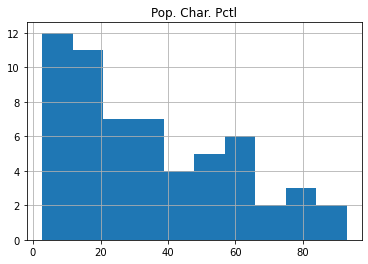

In [6]:
master.hist(column = "Pop. Char. Pctl")


The population characteristic scores are extremely skewed, nowhere near a normal distribution. This tells me that San Diego has many areas where levels of disadvantage in the population are low.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed8dd4cd10>]],
      dtype=object)

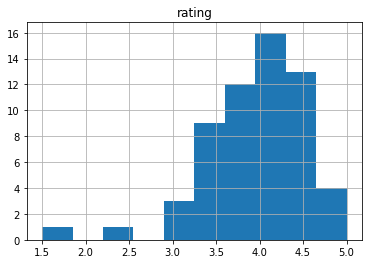

In [7]:
master.hist(column = "rating")

The ratings seem to follow a roughly normal distribution, with a couple of outliers on the lower end. Depending on how many reviews went into those ratings, they may have to be removed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed8dd43890>]],
      dtype=object)

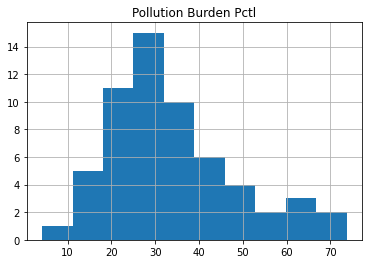

In [8]:
master.hist(column = 'Pollution Burden Pctl')

The pollution burden distribution follows a roughly normal distribution with a skew to the right, indicating that there are some areas which experience significantly more pollutant burden than the majority.

## Ethics & Privacy

   There should be no concerns about ethical issues or invasion of privacy with respect to this study. At no point are any individuals' private information put at risk; in fact, this study does not involve information regarding individuals whatsoever. The data is open for use and therefore no issues regarding permissions should arise either. There is, however, potential for bias in use of Yelp reviews as a proxy for park quality. Reviews will likely come from exclusively English speakers, and also likely come from visitors rather than actual residents living nearby the parks. While the average park ratings are helpful for a relative comparison of parks in various areas, they may not be a perfect metric of park quality. Specifically, they may not adequately reflect the opinions of people who often visit those parks but rather lend disproportionate weight to the impressions of rare visitors.

## Conclusion and Discussion